# Con PyCaret:

### Importo le librerie e leggo i dati:

In [1]:
#import necessary libraries
import pandas as pd
from pycaret.time_series import *

#read SPY data
df = pd.read_csv('spy 1m data.csv', usecols=[1, 2, 3, 4, 5]) #i import 1min data from DukasCopy
df = df.tail(2000) #i select only the last 2000 minutes of data

### Setup iniziale e controllo della stagionalità:

In [2]:
# import TSForecastingExperiment and init the class
from pycaret.time_series import TSForecastingExperiment
exp = TSForecastingExperiment()

# init setup on exp
exp.setup(df, fh = 200, session_id = 123, target = 'close', use_gpu = True, fold=4)

,Description,Value
0,session_id,123
1,Target,close
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(2000, 5)"
5,Transformed data shape,"(2000, 5)"
6,Transformed train set shape,"(1800, 5)"
7,Transformed test set shape,"(200, 5)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

#### Comparo i modelli:

In [3]:
exp.compare_models(sort='MAPE', turbo=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.2623,0.2269,0.0467,0.0599,0.0001,0.0001,0.9934,45.1950
arima,ARIMA,0.4660,0.3850,0.0839,0.1024,0.0002,0.0002,0.9865,0.5475
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,6.1563,4.7026,1.0642,1.1990,0.0019,0.0019,-1.2611,6.1150
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,6.3592,4.8880,1.1046,1.2565,0.0020,0.0020,-1.6027,6.0900
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,7.5656,5.9337,1.3362,1.5427,0.0024,0.0024,-1.3374,3.0700
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,8.5774,6.6675,1.5236,1.7407,0.0027,0.0027,-2.1319,3.9200
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,8.4564,6.4680,1.5207,1.7094,0.0027,0.0027,-2.2156,6.1625
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,8.8203,6.7577,1.5832,1.7823,0.0028,0.0028,-2.3735,3.4100
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,8.8670,6.3801,1.6046,1.7088,0.0029,0.0029,-13.1690,3.2100
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,9.2301,7.2842,1.6388,1.8918,0.0029,0.0029,-2.1025,3.3100


AutoARIMA(random_state=123, sp=6, suppress_warnings=True)

### Creo il modello AutoARIMA e plotto le diagnostiche:

In [3]:
model1 = exp._create_model('auto_arima')
exp.plot_model(model1)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,50629.0000,0.1404,0.1141,0.0230,0.0279,0.0000,0.0000,0.9951
1,50829.0000,0.4214,0.3559,0.0672,0.0836,0.0001,0.0001,0.9981
2,51029.0000,0.2401,0.2034,0.0463,0.0587,0.0001,0.0001,0.9828
3,51229.0000,0.2474,0.2341,0.0502,0.0695,0.0001,0.0001,0.9975
Mean,nan,0.2623,0.2269,0.0467,0.0599,0.0001,0.0001,0.9934
SD,nan,0.1011,0.0865,0.0158,0.0205,0.0000,0.0000,0.0062


In [4]:
exp.plot_model(model1, plot = 'diagnostics', fig_kwargs={"height": 1000, "width": 1800})

In [ ]:
exp.plot_model(model1, plot = 'train_test_split', fig_kwargs={"height": 800, "width": 1000})

In [ ]:
exp.plot_model(model1, plot = 'cv', fig_kwargs={"height": 800, "width": 1200})

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.1846,0.1941,0.0388,0.0589,0.0001,0.0001,0.9968


<Axes: >

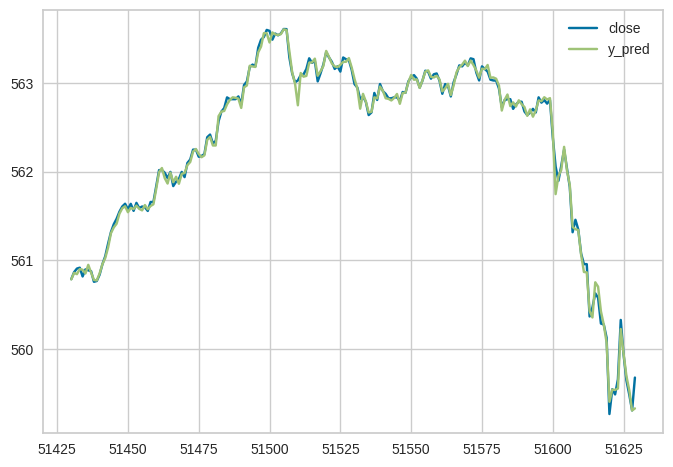

In [8]:
y_predict = exp.predict_model(model1)

# Create a dataframe with the last 200 rows of df and y_pred
df_last_200 = pd.concat([df['close'].tail(200), y_predict], axis=1)

df_last_200.plot()

### Ottimizzazione e salvataggio del modello:

In [ ]:
tuned_model1 = exp.tune_model(model1)

In [ ]:
exp.save_model(tuned_model1, 'tuned AutoARIMA Model')

In [ ]:
exp.load_model('tuned AutoARIMA Model')

# Con pmdarima e sklearn:

In [1]:
import pmdarima as pm
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
df = pd.read_csv('spy 1h data.csv', usecols=[1, 2, 3, 4, 5])

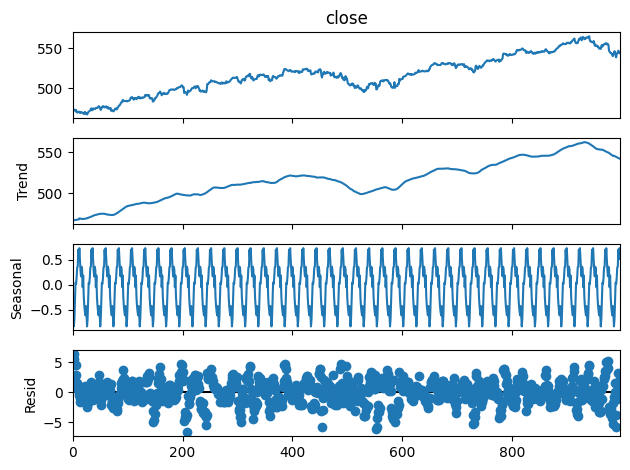

In [4]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df['close'], model='additive', 
                            extrapolate_trend='freq', period=24)

fig = decomposition.plot()



In [11]:
from pmdarima import model_selection
TEST_LENGTH = 100
train, test = model_selection.train_test_split(df['close'], test_size=TEST_LENGTH)

auto_arima = pm.auto_arima(train, seasonal=True,
                           test='adf', with_intercept=False,
                           stepwise=True, trace=True,
                           suppress_warnings=True, m=180)

auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[180]             : AIC=3090.827, Time=117.54 sec
 ARIMA(0,1,0)(0,0,0)[180]             : AIC=3080.132, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[180]             : AIC=3083.373, Time=14.48 sec


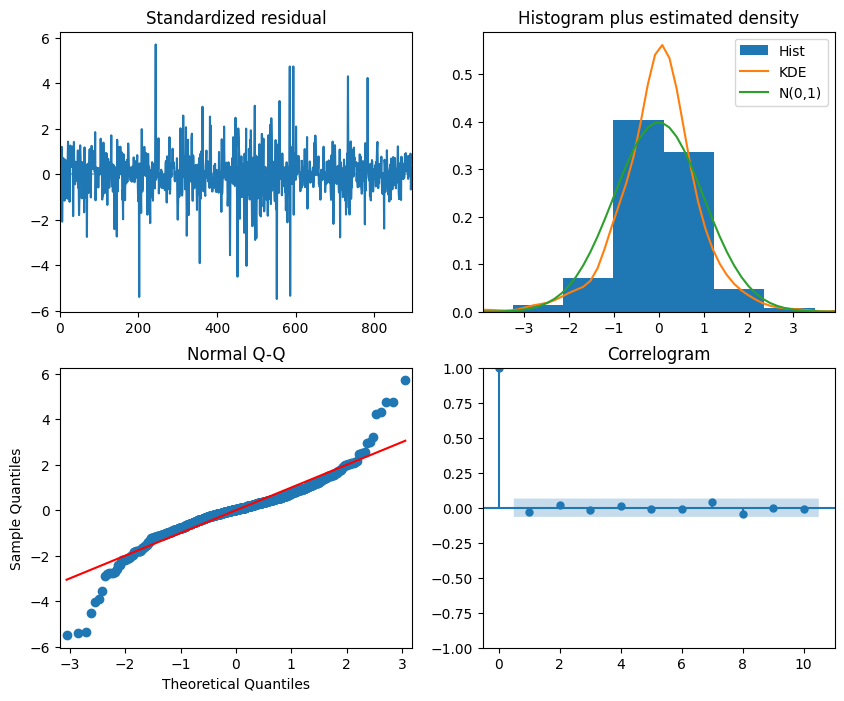

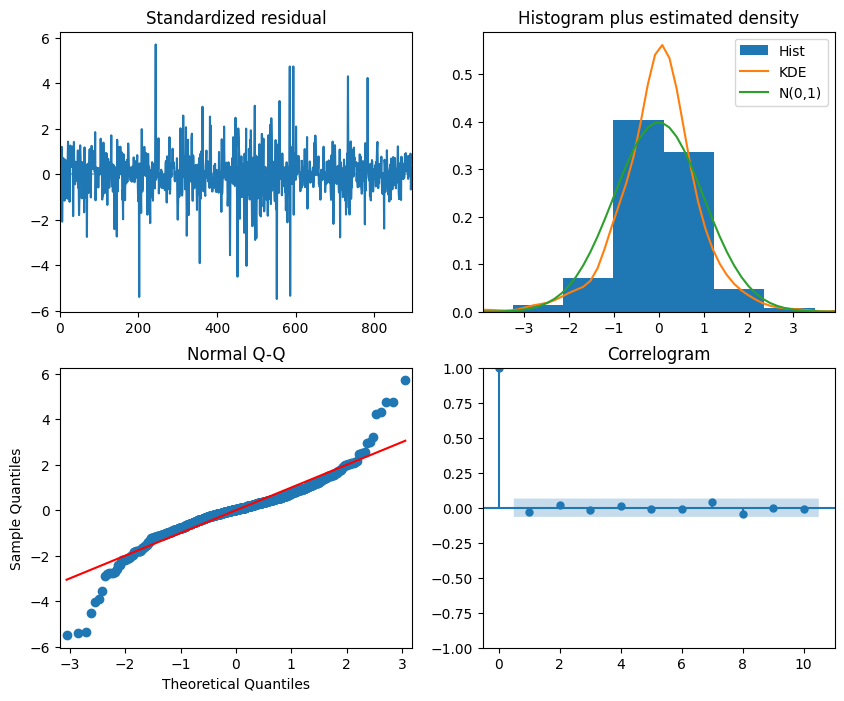

In [ ]:
auto_arima.plot_diagnostics(figsize=(10,8))

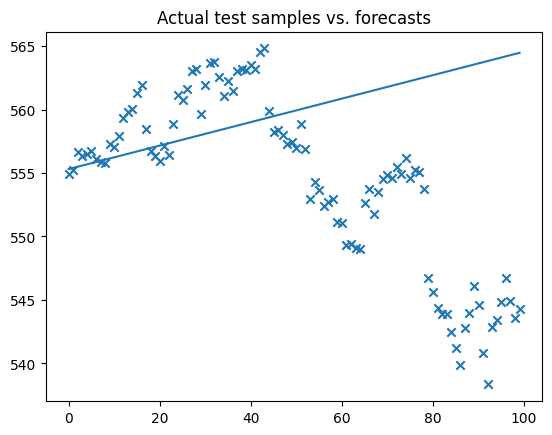

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

#-------------------------------------------------
### NEED TO FIX THE SEASONALITY COMPONENT "m" ###
#-------------------------------------------------

x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, auto_arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()
